In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

In [2]:
# enhanced loop
HepG2_ATAC_H3K27ac_H3K4me3_2_100_all_enhanced_sig = np.load(
    '/home/lmh/work/repos/MINE/analyse/fig3/tss/temp/HepG2_ATAC_H3K27ac_H3K4me3_2_100_all_enhanced_sig.npy',
    allow_pickle=True
).item()

# rpkms info
Homo_sapiens_GRCh38_file = '/data1/lmh_data/MINE/source/Homo_sapiens.GRCh38.84.gtf'
Homo_sapiens_GRCh38 = dict()
with open(Homo_sapiens_GRCh38_file, 'r')as f:
    for line in f:
        datas = line.strip().split()
        if len(datas) < 4:
            continue
        if datas[2] != "gene":
            continue
        gene_id = datas[9].split('"')[1]
        Homo_sapiens_GRCh38[gene_id] = [datas[0], int(datas[3]), int(datas[4])]
RNA_seq_file = '/data1/lmh_data/MINE/source/HepG2/RNA_seq_rpkms.xls'
rna_infos = pd.read_excel(RNA_seq_file)
rna_infos["rna_rpkms_avg"] = rna_infos[["SS_FSU_43_none_RNAseq", "SS_FSU_44_none_RNAseq"]].mean(axis=1)
rna_infos = rna_infos.loc[rna_infos["rna_rpkms_avg"]>0]
rna_infos.insert(rna_infos.shape[1], 'Chromosome', '')
rna_infos.insert(rna_infos.shape[1], 'Gene start (bp)', 0)
rna_infos.insert(rna_infos.shape[1], 'Gene end (bp)', 0)
for index in rna_infos.index:
    if rna_infos.loc[index]["Geneid"] not in Homo_sapiens_GRCh38.keys():
        continue
    data = Homo_sapiens_GRCh38[rna_infos.loc[index]["Geneid"]]
    rna_infos.loc[index, "Chromosome"] = data[0]
    rna_infos.loc[index, "Gene start (bp)"] = data[1]
    rna_infos.loc[index, "Gene end (bp)"] = data[2]

# seq file path
auxiliary_files_path = '/data1/lmh_data/MINE/source/HepG2'
CTCF_path = os.path.join(auxiliary_files_path, 'CTCF_peaks.bed')
POLR2A_path = os.path.join(auxiliary_files_path, 'POLR2A_peaks.bed')
EP300_path = os.path.join(auxiliary_files_path, 'EP300_peaks.bed')

H3K27ac_path = os.path.join(auxiliary_files_path, 'H3K27ac_peaks.bed')
H3K4me3_path = os.path.join(auxiliary_files_path, 'H3K4me3_peaks.bed')

In [3]:
def get_score(sigs, _chr, _start, _end):
    length = int((_end - _start) / 10 + 1)
    scores = np.zeros(length)
    for loop in sigs[_chr]:
        for anchor in loop:
            if anchor >= _start and anchor < _end + 10:
                scores[int((anchor-_start)/10)] += 1
    return scores

def get_rpkms_score(infos, _chr, _start, _end):
    length = int((_end - _start) / 10 + 1)
    scores = np.zeros(length)
    temp = infos.loc[infos["Chromosome"]==str(_chr)]
    for i in range(length):
        tmp = temp.loc[temp["Gene start (bp)"]>=(_start+i*10)*1000].loc[temp["Gene end (bp)"]<(_start+(i+1)*10)*1000]
        scores[i] = tmp[["rna_rpkms_avg"]].sum()
    return scores

def get_seq_score(chip_seq_path, _chr, _start, _end):
    length = int((_end - _start) / 10 + 1)
    scores = np.zeros(length)
    with open(chip_seq_path)as f:
        for line in f:
            datas = line.strip().split()
            if datas[0][3:] != str(_chr):
                continue
            left, right = int(int(datas[1])/1000), int(int(datas[2])/1000)
            if left >= _start and right < _end + 10:
                scores[int((left-_start)/10)] += 1
    return scores

In [4]:
_ranges = {
    'active_147': [1, 143690, 147250],
    'active_1379': [2, 88740, 98390],
    'active_1727': [3, 43530, 50620],
    'active_1372': [2, 74890, 85060] 
}

PASTIS_out_path = '/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac_H3K4me3/analyse/HepG2_ATAC_H3K27ac_H3K4me3/experiment/SDOC/out_with_active_loop_anchor/HepG2/PASTIS_out'
def read_PASTIS_out(file_path):
    _p = []
    with open(file_path, "r") as f:
        datas = f.readlines()
        for data in datas:
            _datas = data.split()
            _data = [np.nan if d == 'nan' else float(d) for d in _datas]
            _p.append(_data)
    return _p

points = dict()
for key in _ranges.keys():
    _range = _ranges[key]
    file_name = 'PM2.chr{}_{}000_{}000'.format(_range[0], _range[1], _range[2])

    points[key] = np.array(read_PASTIS_out(os.path.join(PASTIS_out_path, file_name)))
    
active_147 = points['active_147']
active_1379 = points['active_1379']
active_1727 = points['active_1727']
active_1372 = points['active_1372']


In [5]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap

def show(points, scores, title, sparseness=True):
    very_large = 24; large = 22; med = 16; small = 12
    params = {'axes.titlesize': very_large,
              'legend.fontsize': med,
              'figure.figsize': (10, 10),
              'axes.labelsize': large,
              'axes.titlesize': large,
              'xtick.labelsize': large,
              'ytick.labelsize': large,
              'figure.titlesize': very_large,
              'lines.linewidth': 2}
    plt.rcParams.update(params)
    
    font = {'family': 'sans-serif', 'sans-serif': 'Arial'}
    plt.rc('font', **font)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    ax.plot(points[:, 0], points[:, 1], points[:, 2], '-', linewidth=5)
    if sparseness:
        nonzero_index = np.argwhere((scores!=0) & (~np.isnan(scores))).reshape(-1)
        scatter = ax.scatter(
            points[nonzero_index, 0], points[nonzero_index, 1], points[nonzero_index, 2],
            c=scores[nonzero_index], cmap=truncate_colormap(plt.get_cmap("Reds"), 0.3, 1), s=very_large*2)
    else:
        scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=scores, cmap="Reds")
    fig.colorbar(scatter, ax=ax, fraction=0.02)
    ax.grid(False)
    ax.axis("off")

    plt.savefig('figure_file/3D/{}.pdf'.format(title), format='pdf', bbox_inches='tight')
    plt.show()

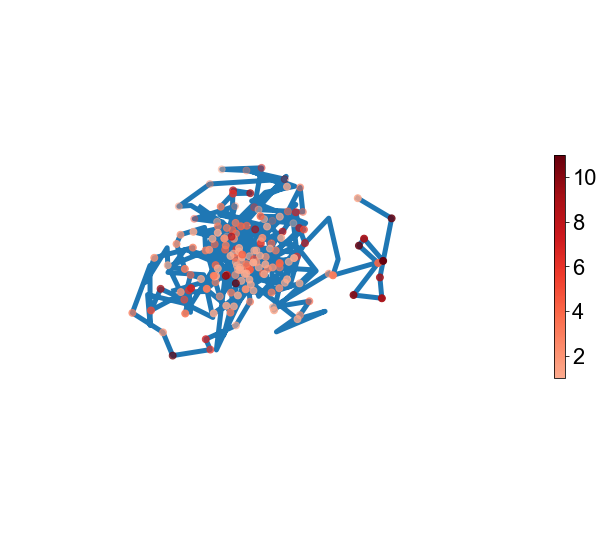

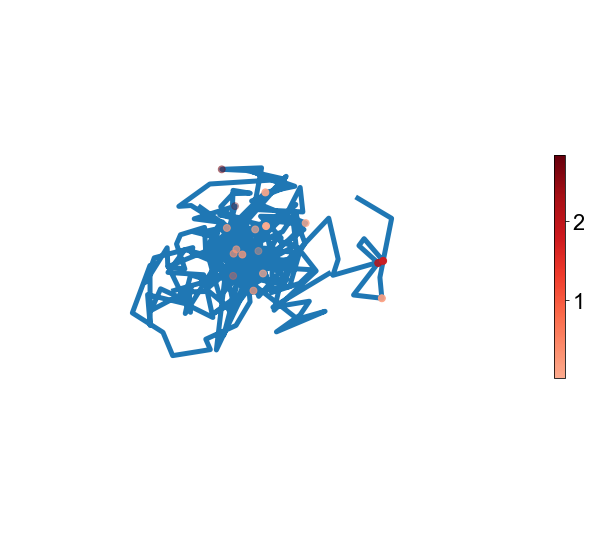

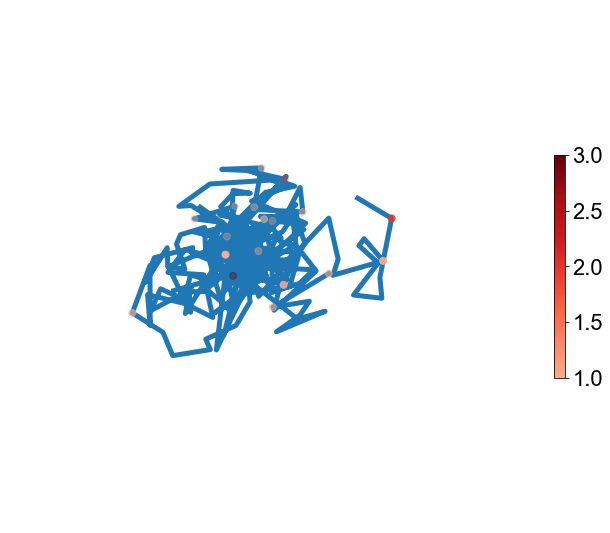

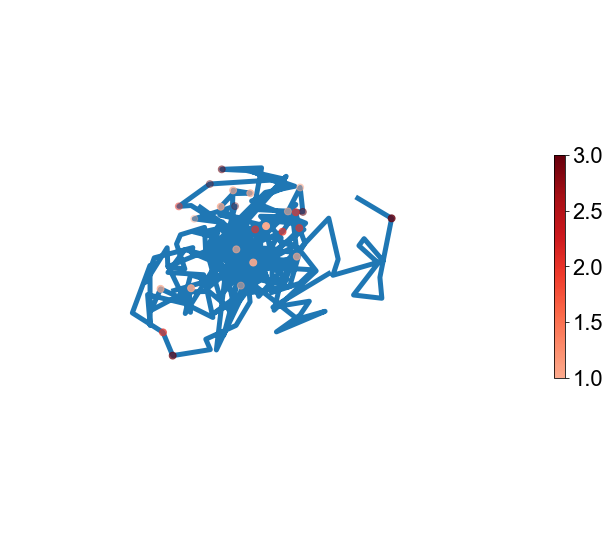

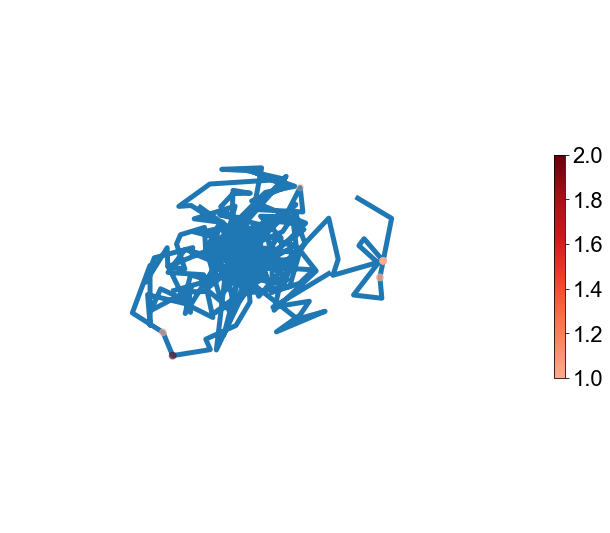

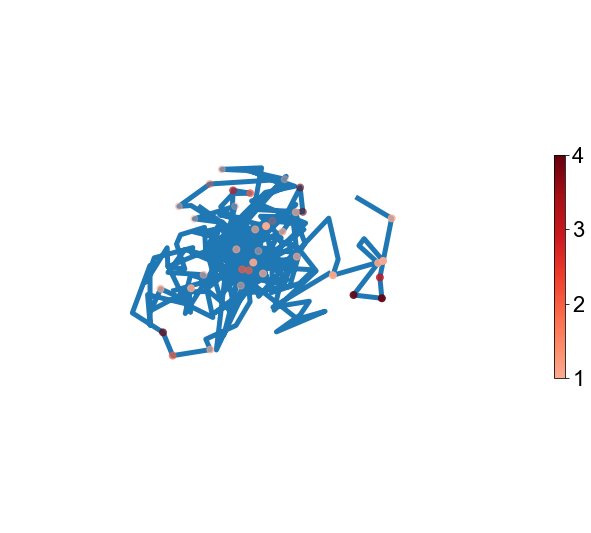

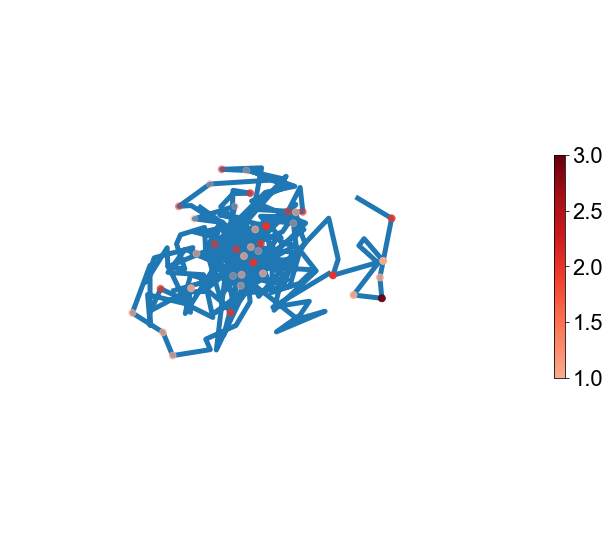

In [6]:
_range, _points = _ranges['active_147'], active_147
scores = get_score(HepG2_ATAC_H3K27ac_H3K4me3_2_100_all_enhanced_sig, _range[0], _range[1], _range[2])
show(_points, scores, 'anchor(active ultra high)')
scores = get_rpkms_score(rna_infos, _range[0], _range[1], _range[2])
show(_points, np.log1p(scores), 'rpkms(active ultra high)', True)

scores = get_seq_score(CTCF_path, _range[0], _range[1], _range[2])
show(_points, scores, 'CTCF(active ultra high)')
scores = get_seq_score(POLR2A_path, _range[0], _range[1], _range[2])
show(_points, scores, 'POLR2A(active ultra high)')
scores = get_seq_score(EP300_path, _range[0], _range[1], _range[2])
show(_points, scores, 'EP300(active ultra high)')

scores = get_seq_score(H3K27ac_path, _range[0], _range[1], _range[2])
show(_points, scores, 'H3K27ac(active ultra high)')
scores = get_seq_score(H3K4me3_path, _range[0], _range[1], _range[2])
show(_points, scores, 'H3K4me3(active ultra high)')

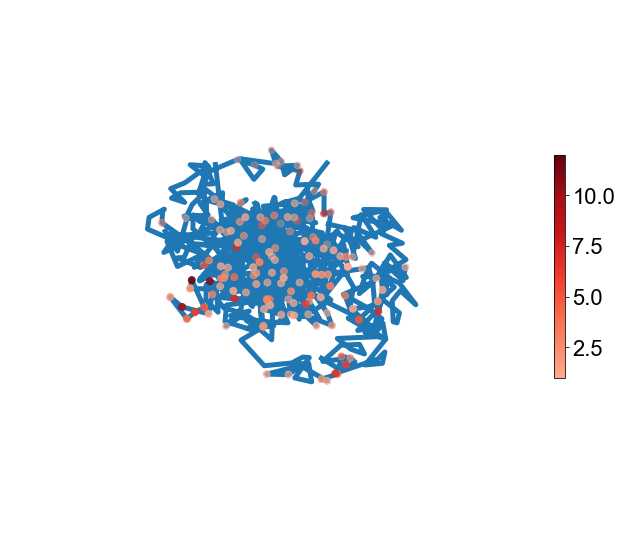

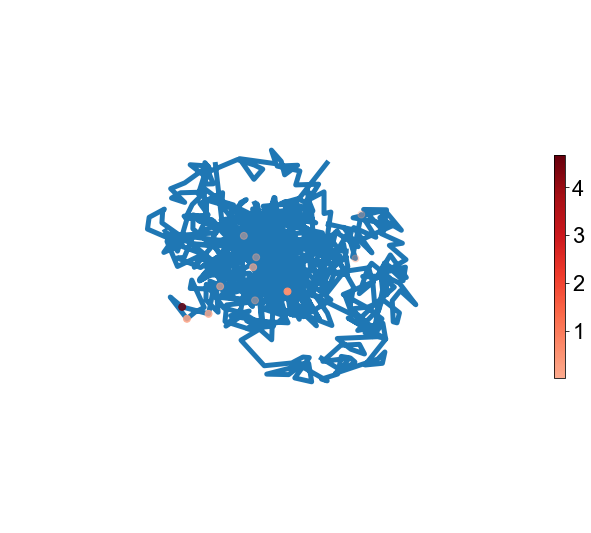

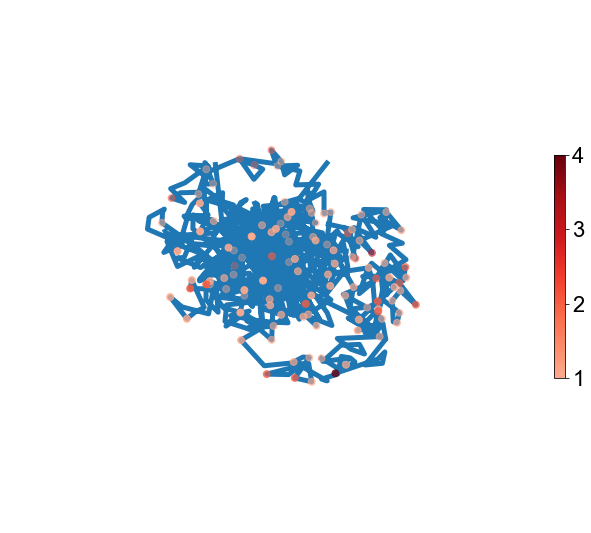

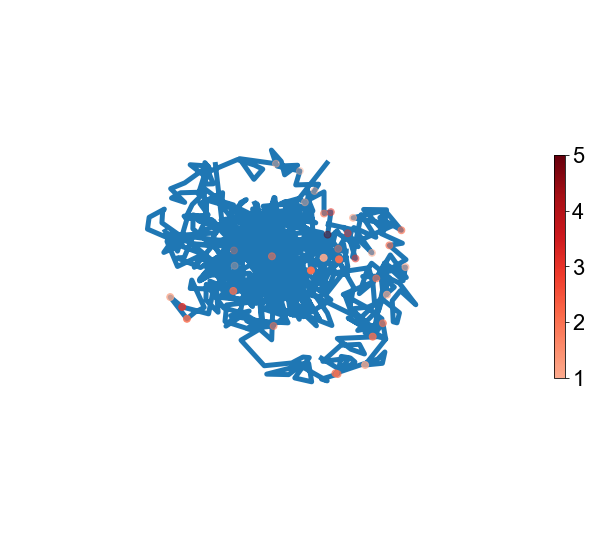

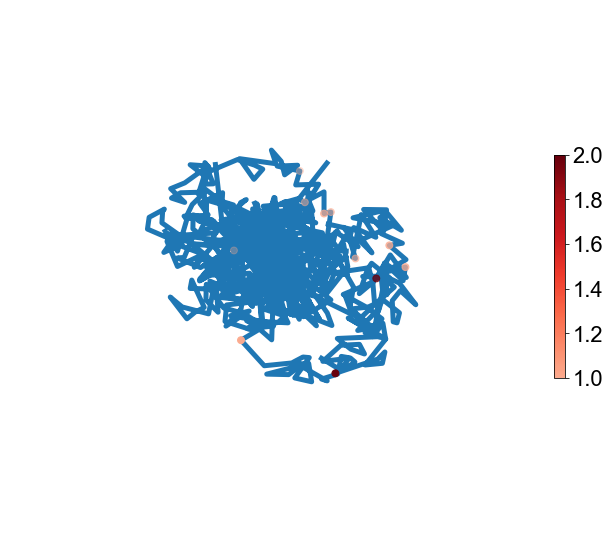

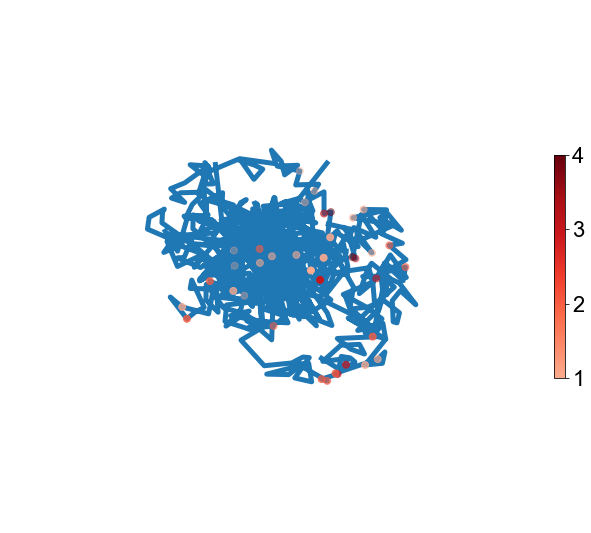

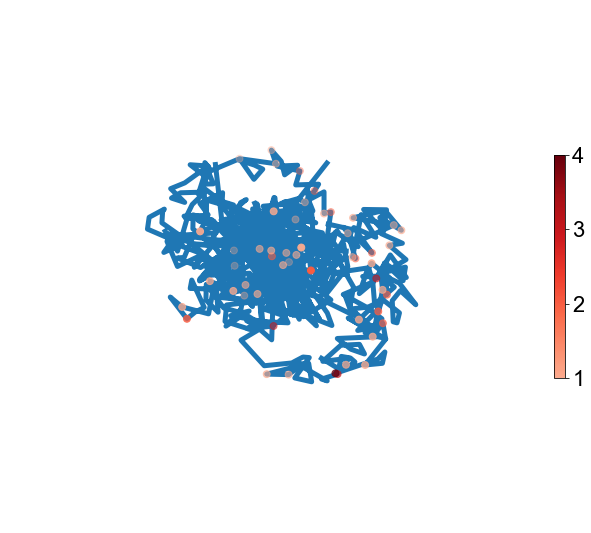

In [7]:
_range, _points = _ranges['active_1379'], active_1379
scores = get_score(HepG2_ATAC_H3K27ac_H3K4me3_2_100_all_enhanced_sig, _range[0], _range[1], _range[2])
show(_points, scores, 'anchor(active high)')
scores = get_rpkms_score(rna_infos, _range[0], _range[1], _range[2])
show(_points, np.log1p(scores), 'rpkms(active high)', True)

scores = get_seq_score(CTCF_path, _range[0], _range[1], _range[2])
show(_points, scores, 'CTCF(active high)')
scores = get_seq_score(POLR2A_path, _range[0], _range[1], _range[2])
show(_points, scores, 'POLR2A(active high)')
scores = get_seq_score(EP300_path, _range[0], _range[1], _range[2])
show(_points, scores, 'EP300(active high)')

scores = get_seq_score(H3K27ac_path, _range[0], _range[1], _range[2])
show(_points, scores, 'H3K27ac(active high)')
scores = get_seq_score(H3K4me3_path, _range[0], _range[1], _range[2])
show(_points, scores, 'H3K4me3(active high)')

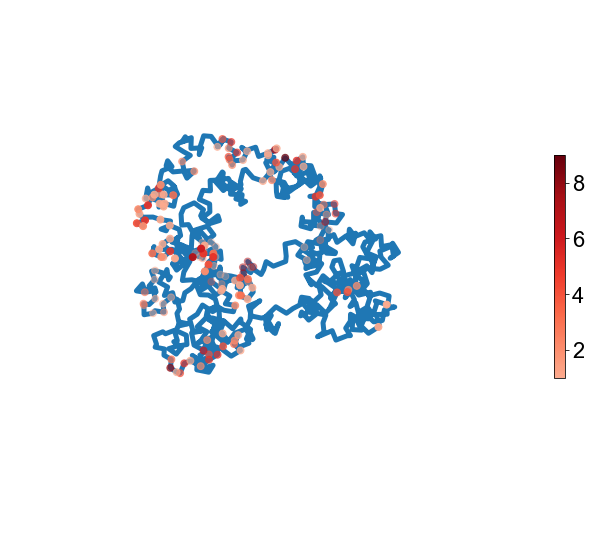

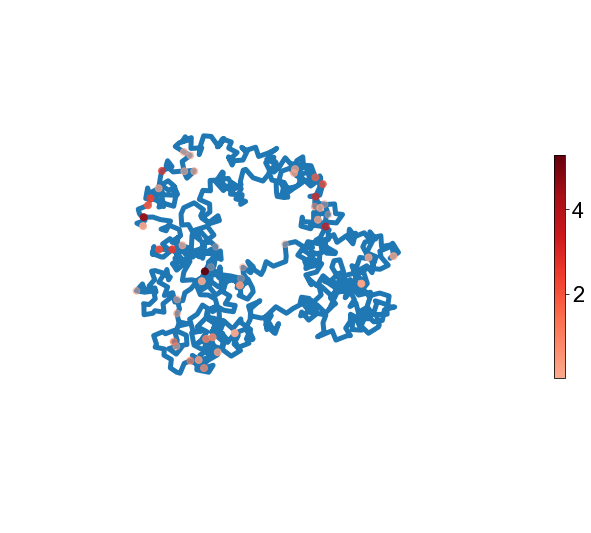

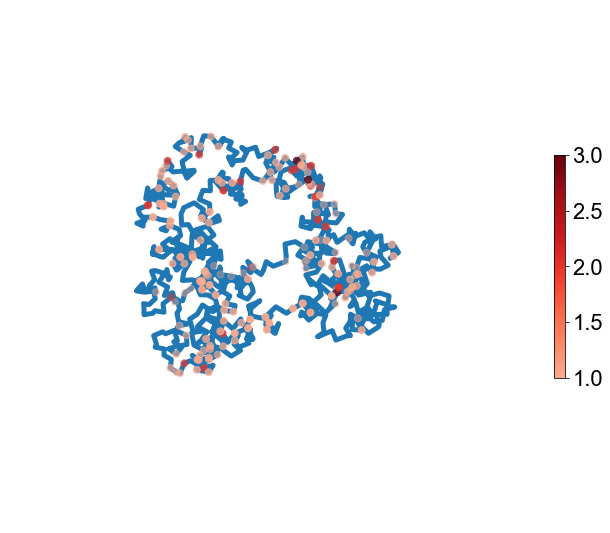

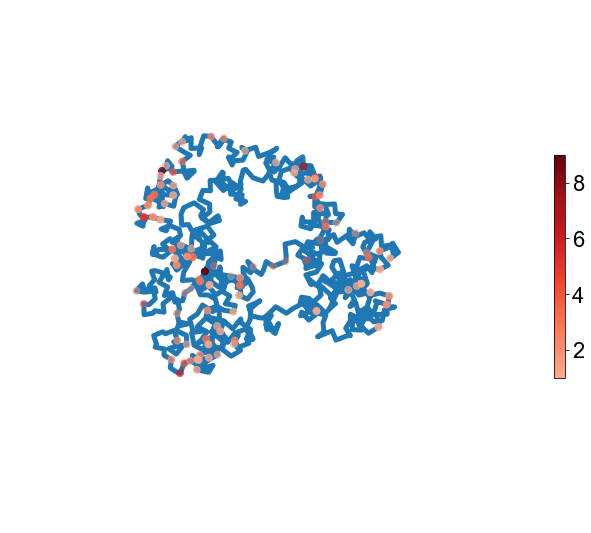

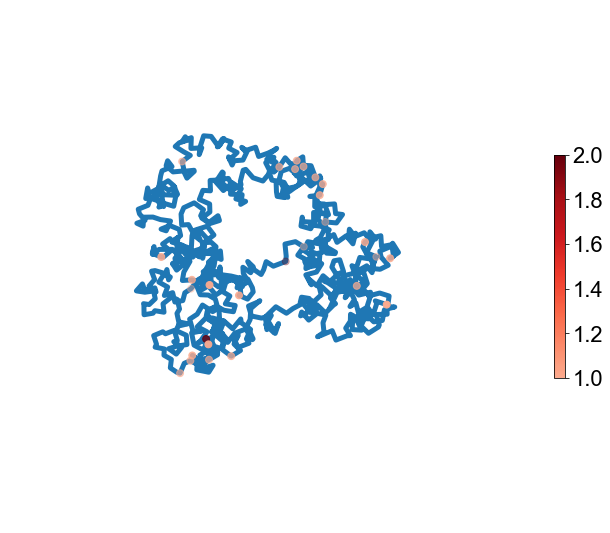

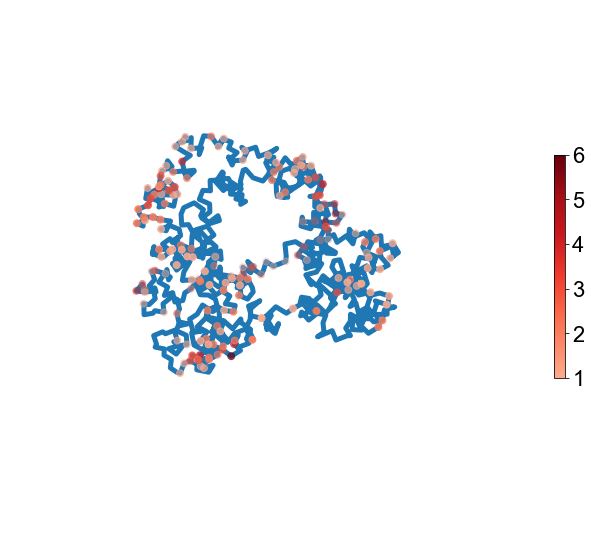

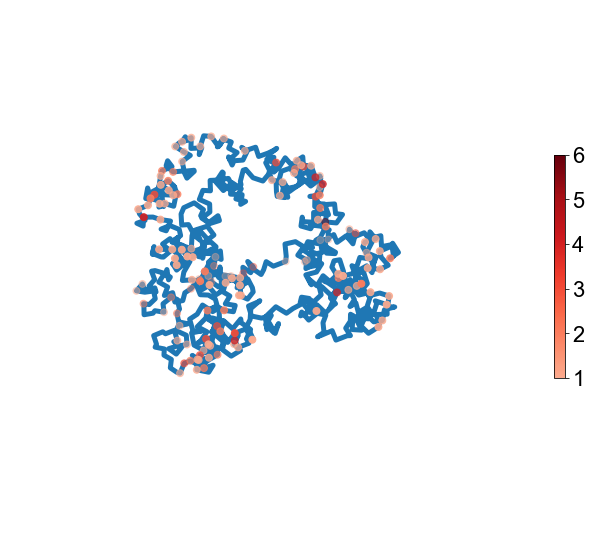

In [8]:
_range, _points = _ranges['active_1727'], active_1727
scores = get_score(HepG2_ATAC_H3K27ac_H3K4me3_2_100_all_enhanced_sig, _range[0], _range[1], _range[2])
show(_points, scores, 'anchor(active middle)')
scores = get_rpkms_score(rna_infos, _range[0], _range[1], _range[2])
show(_points, np.log1p(scores), 'rpkms(active middle)', True)

scores = get_seq_score(CTCF_path, _range[0], _range[1], _range[2])
show(_points, scores, 'CTCF(active middle)')
scores = get_seq_score(POLR2A_path, _range[0], _range[1], _range[2])
show(_points, scores, 'POLR2A(active middle)')
scores = get_seq_score(EP300_path, _range[0], _range[1], _range[2])
show(_points, scores, 'EP300(active middle)')

scores = get_seq_score(H3K27ac_path, _range[0], _range[1], _range[2])
show(_points, scores, 'H3K27ac(active middle)')
scores = get_seq_score(H3K4me3_path, _range[0], _range[1], _range[2])
show(_points, scores, 'H3K4me3(active middle)')

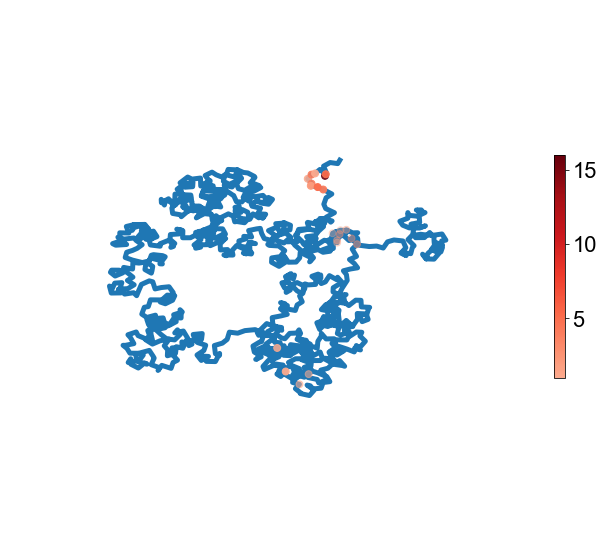

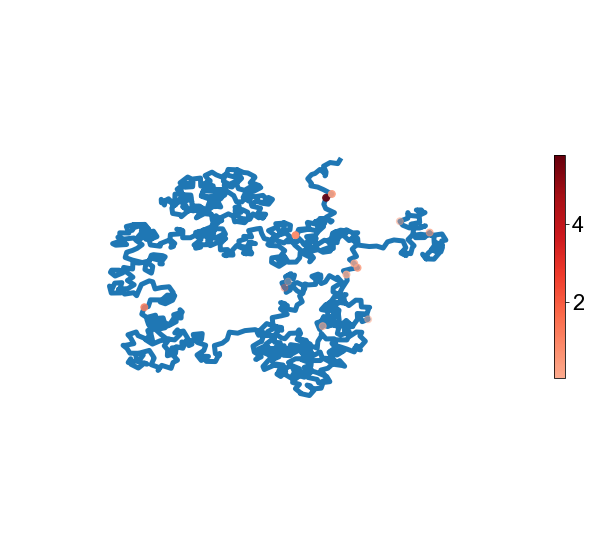

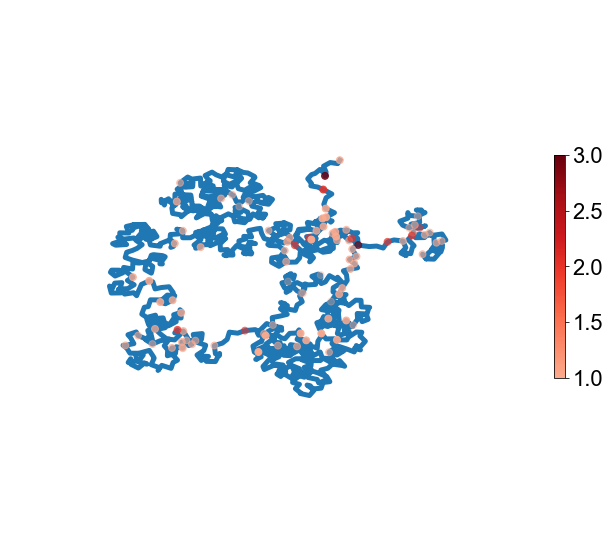

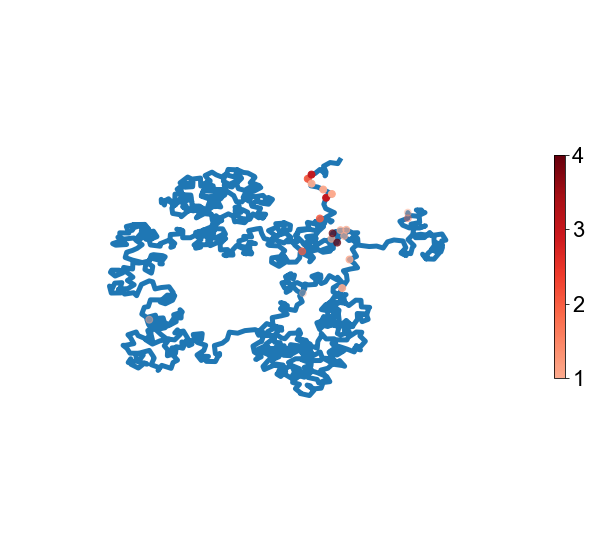

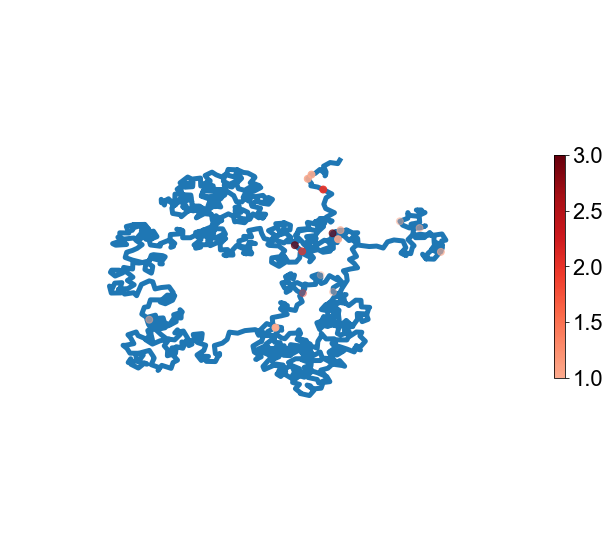

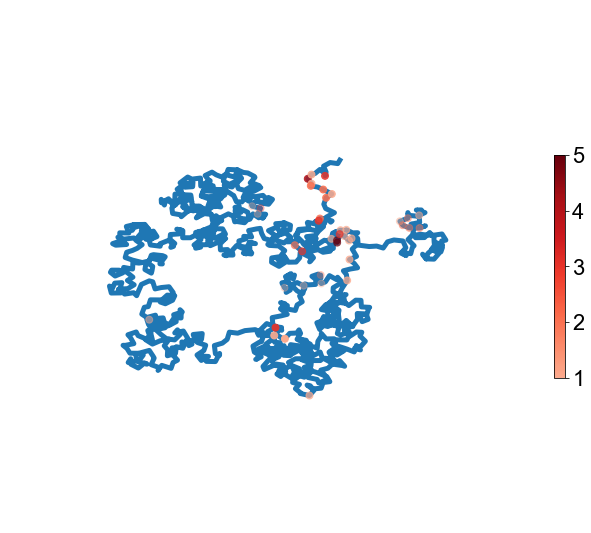

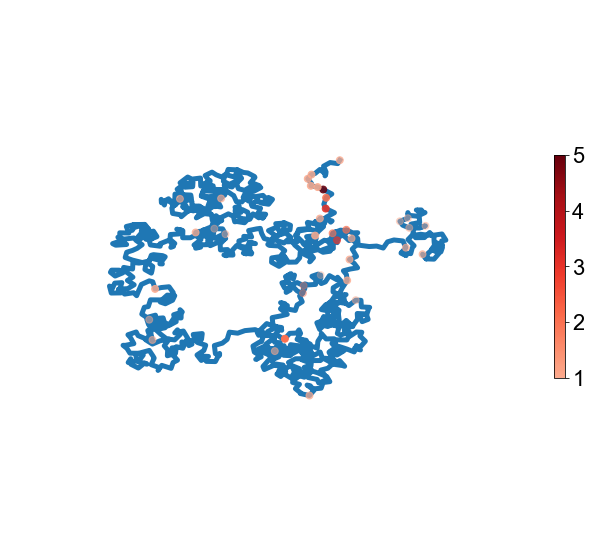

In [9]:
_range, _points = _ranges['active_1372'], active_1372
scores = get_score(HepG2_ATAC_H3K27ac_H3K4me3_2_100_all_enhanced_sig, _range[0], _range[1], _range[2])
show(_points, scores, 'anchor(active low)')
scores = get_rpkms_score(rna_infos, _range[0], _range[1], _range[2])
show(_points, np.log1p(scores), 'rpkms(active low)', True)

scores = get_seq_score(CTCF_path, _range[0], _range[1], _range[2])
show(_points, scores, 'CTCF(active low)')
scores = get_seq_score(POLR2A_path, _range[0], _range[1], _range[2])
show(_points, scores, 'POLR2A(active low)')
scores = get_seq_score(EP300_path, _range[0], _range[1], _range[2])
show(_points, scores, 'EP300(active low)')

scores = get_seq_score(H3K27ac_path, _range[0], _range[1], _range[2])
show(_points, scores, 'H3K27ac(active low)')
scores = get_seq_score(H3K4me3_path, _range[0], _range[1], _range[2])
show(_points, scores, 'H3K4me3(active low)')

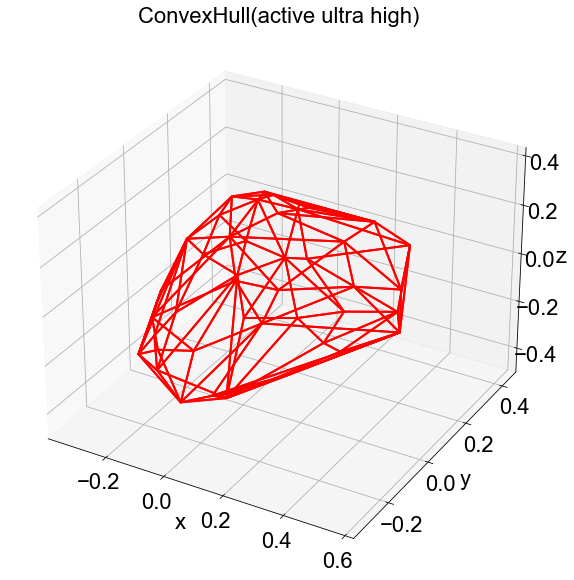

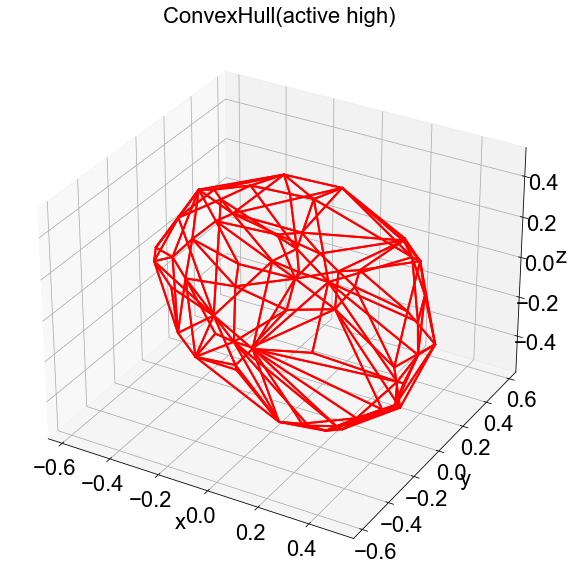

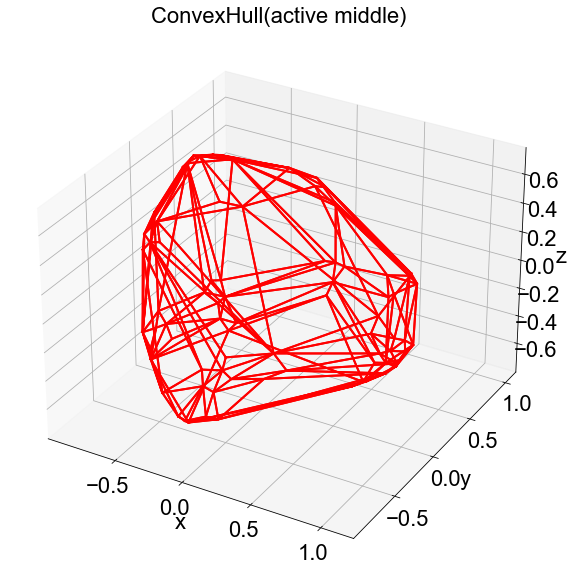

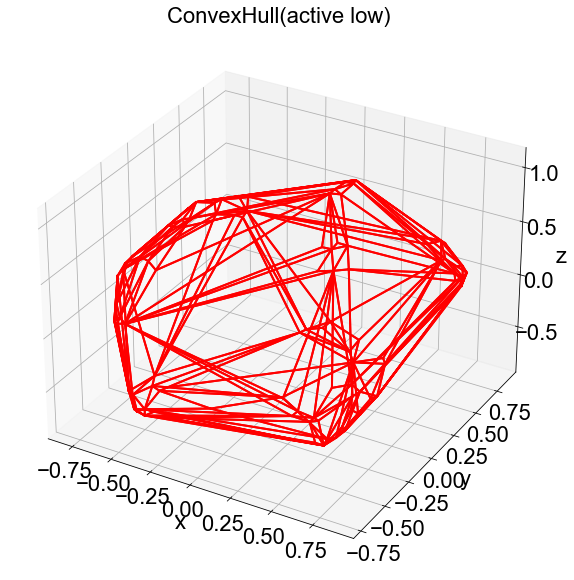

In [10]:
def show(points, title):
    pts = np.array(points)
    mask = np.any(np.isnan(pts), axis=1)
    pts = pts[~mask]

    hull = ConvexHull(pts)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # 12 = 2 * 6 faces are the simplices (2 simplices per square face)
    for s in hull.simplices:
        s = np.append(s, s[0])  # Here we cycle back to the first coordinate
        ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")
    ax.set_title(title)

    # Make axis label
    for i in ["x", "y", "z"]:
        eval("ax.set_{:s}label('{:s}')".format(i, i))

    plt.show()

show(active_147, 'ConvexHull(active ultra high)')
show(active_1379, 'ConvexHull(active high)')
show(active_1727, 'ConvexHull(active middle)')
show(active_1372, 'ConvexHull(active low)')